# Question 2: Classification
## Machine Learning Foundations with Python 
### 90-803 - Spring 2024
### Sprint Team #17
### Name:  Jewel Yoko Kentilitisca, Hannah Ngyugen, Quintessa Guegerich


### Can we predict the impact of rising temperatures on changes in property prices in areas designated as "climate ready"?
Reference for "climate ready" states: (https://www.architecturaldigest.com/reviews/solar/most-climate-resilient-cities)

   Target variable: The target variable for this classification problem is the direction of the impact of rising temperatures on property prices in a given area. It is represented as a categorical variable with three levels:

    (a) 3 - Positive impact: Rising temperatures lead to a significant increase in property prices 
    (b) 2 - Medium impact: Rising temperatures lead to a moderate increase in property prices
    (c) 1 - Negative impact: Rising temperatures lead to a decrease in property prices


### Ideas 
   (a) Generate a heatmap to visualize the correlation matrix between temperature anomalies and other variables, including housing price changes. 

In [35]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.preprocessing import OneHotEncoder
import time

from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE

# Importing preprocessing and modeling libraries
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

### Preprocessing the Data

In [36]:
#Dictionary for state codes for us to be able to merge another dataset for longitude and latitude
state_codes = {
    'AL': '01',
    'AK': '02',
    'AZ': '04',
    'AR': '05',
    'CA': '06',
    'CO': '08',
    'CT': '09',
    'DE': '10',
    'FL': '12',
    'GA': '13',
    'HI': '15',
    'ID': '16',
    'IL': '17',
    'IN': '18',
    'IA': '19',
    'KS': '20',
    'KY': '21',
    'LA': '22',
    'ME': '23',
    'MD': '24',
    'MA': '25',
    'MI': '26',
    'MN': '27',
    'MS': '28',
    'MO': '29',
    'MT': '30',
    'NE': '31',
    'NV': '32',
    'NH': '33',
    'NJ': '34',
    'NM': '35',
    'NY': '36',
    'NC': '37',
    'ND': '38',
    'OH': '39',
    'OK': '40',
    'OR': '41',
    'PA': '42',
    'RI': '44',
    'SC': '45',
    'SD': '46',
    'TN': '47',
    'TX': '48',
    'UT': '49',
    'VT': '50',
    'VA': '51',
    'WA': '53',
    'WV': '54',
    'WI': '55',
    'WY': '56'
}


In [37]:
#Reading the CSVs
merged_data = pd.read_csv('all_data.csv')
merged_data.head()
merged_data['StateFP'] = merged_data['StateAbbrv'].map(state_codes)
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merged_data.merge(us_counties, left_on=['RegionName', 'StateFP'], right_on=['NAMELSAD', 'STATEFP'])

merged_data.head()

#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
merged_data[columns_to_float] = merged_data[columns_to_float].astype(float)

#Filtering for states we wanna deep dive in
filtered_states = merged_data[merged_data['State'].isin(['CO', 'NY', 'CA', "FL", 'IL', 'PA', 'NC', 'TX', 'WA', "NM", "UT"])]


### Figuring out how to make this into a classification problem

1. Make temperature into a multiclass of 1 = Low, 2 = Medium, and 3 - High in terms of temperature risk based on anomalies [did not go with this option]
2. Look at the ratio changes between purchase price, bottom tier average home value estimate, and top tier average home value estimate, grouping by month/year.
3. Include temperature anomaly data into one combined value reflecting the impact on housing prices, trying to calculate by putting weights?

    -Normalizing the Temperature Anomaly Data: Ensure that the temperature anomaly data is on a similar scale as the housing price data. This might involve scaling or normalization.

    -Define Weights: Assign weights to the housing price change and temperature anomaly change based on their relative importance in influencing housing prices. These weights can be subjective.

    -Calculate Combined Impact: Multiply the percentage change in housing prices and the normalized temperature anomaly data by their respective weights, and then add them together to get a combined impact value.

### Intention: Look if positive values may indicate that higher temperature anomalies are associated with a higher likelihood of a certain class (higher percentage change in housing prices, both for bottom tier and top tier), while negative values may indicate the opposite.

### The idea was to make a ratio change/ percentage change of each year of bottom tier home value prices, top tier home value prices, and purchase price 

In [38]:
# Group the data by 'County Name' and calculate the percentage change for each group
filtered_states['Ratio_Change_Bottom_Tier'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Bottom-Tier Average Home Value Estimate'].pct_change()*100
filtered_states['Ratio_Change_Top_Tier'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Top-Tier Average Home Value Estimate'].pct_change()*100
filtered_states['Ratio_Change'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Purchase Price ($thou)'].pct_change()*100

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_8905/3484926559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['Ratio_Change_Bottom_Tier'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Bottom-Tier Average Home Value Estimate'].pct_change()*100
/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_8905/3484926559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['Ratio_Change_Top_Tier'] = filtered_states.groupby(['Regio

### Standardizing Temperature Anomaly 

In [57]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the 'Anomaly (1901-2000 base period)' column
scaler.fit(filtered_states[['Anomaly (1901-2000 base period)']])

# Transform the 'Anomaly (1901-2000 base period)' column using the fitted scaler
filtered_states['Normalized_Temperature_Anomaly'] = scaler.transform(filtered_states[['Anomaly (1901-2000 base period)']])

filtered_states.head()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,ALAND,AWATER,INTPTLAT,INTPTLON,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change,Normalized_Temperature_Anomaly,bottom_tier_multiclass,top_tier_multiclass
24,19022,2001,1,134011.292609,434953.121289,47.3,-0.5,47.8,0.57,7.69,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.106132,8.685910,8.582949,-0.673337,3,3
25,19023,2001,1,134011.292609,434953.121289,47.3,-0.5,47.8,0.63,7.40,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.106132,8.685910,13.009592,-0.673337,3,3
26,20648,2001,2,134495.031712,436357.668087,47.1,-2.4,49.5,0.53,7.23,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.365314,8.909603,14.988426,-1.287736,3,3
27,20649,2001,2,134495.031712,436357.668087,47.1,-2.4,49.5,0.61,7.22,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.365314,8.909603,17.348809,-1.287736,3,3
28,22276,2001,3,135191.995137,438477.032394,55.4,3.3,52.1,0.54,7.17,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.478098,8.988295,17.015263,0.555460,3,3


### Creating the Weights?

In [58]:
# Define weights for housing price change and temperature anomaly
housing_price_weight = 0.7
temperature_anomaly_weight = 0.3

### Looking at the spread of the data

count    174196.000000
mean          2.718901
std           6.875744
min         -45.222030
25%          -0.706373
50%           2.769268
75%           6.065272
max          56.510949
Name: Ratio_Change_Top_Tier, dtype: float64

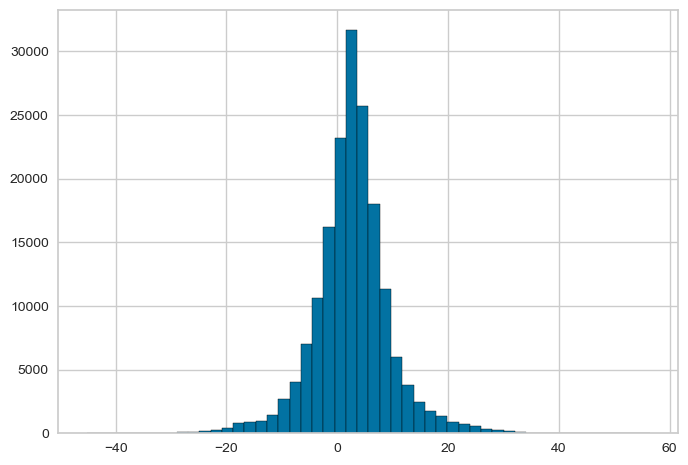

In [40]:
plt.hist(filtered_states['Ratio_Change_Top_Tier'], bins=50, edgecolor='black') 
filtered_states['Ratio_Change_Top_Tier'].describe()

count    174196.000000
mean          4.124316
std           8.264392
min         -48.460624
25%          -0.771900
50%           4.006128
75%           8.975001
max          65.666702
Name: Ratio_Change_Bottom_Tier, dtype: float64


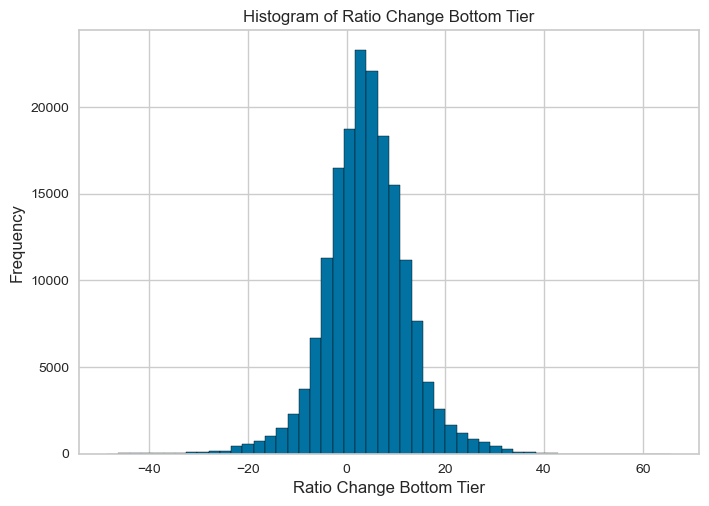

In [41]:
# Plot the histogram
plt.hist(filtered_states['Ratio_Change_Bottom_Tier'], bins=50, edgecolor='black') 

# Add labels and title
plt.xlabel('Ratio Change Bottom Tier')
plt.ylabel('Frequency')
plt.title('Histogram of Ratio Change Bottom Tier')

# Show descriptive statistics
print(filtered_states['Ratio_Change_Bottom_Tier'].describe())

# Show the plot
plt.show()

count    174196.000000
mean          3.755040
std          15.684930
min         -50.793651
25%          -2.005835
50%           2.431507
75%           7.634265
max         139.516129
Name: Ratio_Change, dtype: float64

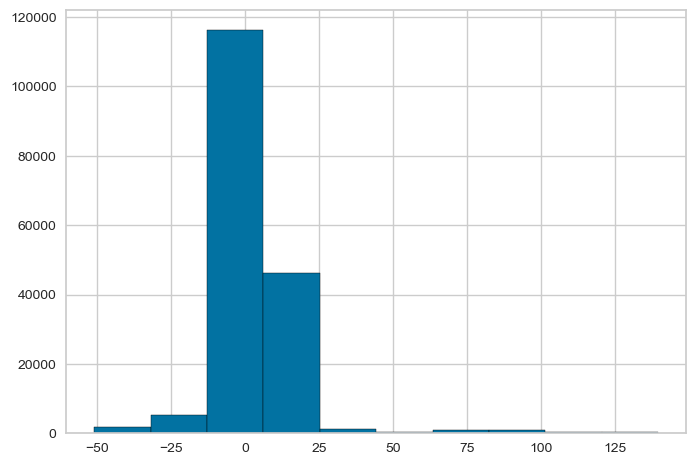

In [42]:
plt.hist(filtered_states['Ratio_Change'], bins=10, edgecolor='black') 
filtered_states['Ratio_Change'].describe()

In [43]:
#Checking the data
los_angeles_data = filtered_states[filtered_states['RegionName'] == 'Los Angeles County']

# Print the filtered data
los_angeles_data.head(50)

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change,Normalized_Temperature_Anomaly
0,0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,0.955859
1,1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,0.955859
2,1566,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,-0.141947
3,1567,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,-0.141947
4,3136,2000-03-31,2000,3,Los Angeles County,CA,123487.708531,402315.707957,53.8,1.7,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,0.051784
5,3137,2000-03-31,2000,3,Los Angeles County,CA,123487.708531,402315.707957,53.8,1.7,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,0.051784
6,4708,2000-04-30,2000,4,Los Angeles County,CA,124505.819878,405640.027081,60.6,4.5,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,0.955859
7,4709,2000-04-30,2000,4,Los Angeles County,CA,124505.819878,405640.027081,60.6,4.5,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,0.955859
8,6284,2000-05-31,2000,5,Los Angeles County,CA,125793.575881,409815.977175,66.0,4.7,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,1.020436
9,6285,2000-05-31,2000,5,Los Angeles County,CA,125793.575881,409815.977175,66.0,4.7,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",NaN,NaN,NaN,1.020436


In [44]:
#Looking at who has the highest ratio change for purchase price
top_ratio_changes = filtered_states.sort_values(by='Ratio_Change', ascending=False)
top_ratio_changes.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change,Normalized_Temperature_Anomaly
504602,334966,2012-11-30,2012,11,Austin County,TX,90365.644524,420165.208767,62.2,2.7,...,A,1.674416e+09,25596214.0,29.891901,-96.270170,"POLYGON ((-96.11996 29.84380, -96.12131 29.841...",3.522916,0.744113,139.516129,0.374668
190546,333798,2012-11-30,2012,11,Lincoln County,NC,91204.212912,307684.066012,46.8,-1.8,...,A,7.662399e+08,23350160.0,35.488491,-81.226893,"POLYGON ((-81.53749 35.56443, -81.53744 35.564...",3.080642,4.076780,139.516129,-1.078310
461148,333836,2012-11-30,2012,11,Henderson County,TX,64952.376464,298311.828894,57.5,2.2,...,A,2.263082e+09,193353703.0,32.211633,-95.853418,"POLYGON ((-95.67753 32.05163, -95.68279 32.050...",0.782798,1.551029,139.516129,0.213226
254086,334428,2012-11-30,2012,11,Stevens County,WA,90934.147912,257089.769140,35.8,3.6,...,A,6.415666e+09,162933477.0,48.388728,-117.854455,"POLYGON ((-117.86678 47.84506, -117.86690 47.8...",6.687885,1.340385,139.516129,0.665263
423500,333176,2012-11-30,2012,11,Sangamon County,IL,63514.792138,217101.947830,42.6,1.1,...,A,2.248721e+09,22731649.0,39.756886,-89.662435,"POLYGON ((-89.61745 39.52433, -89.61746 39.524...",4.401401,4.033634,139.516129,-0.141947


In [45]:
#Looking at who has the highest ratio change for bottom tier average home value estimates
top_ratio_changes_bottom = filtered_states.sort_values(by='Ratio_Change_Bottom_Tier', ascending=False)
top_ratio_changes_bottom.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change,Normalized_Temperature_Anomaly
75711,130801,2006-04-30,2006,4,Collier County,FL,233066.289844,999969.347983,74.9,2.3,...,A,5.171811e+09,1.575211e+09,26.118786,-81.400955,"POLYGON ((-81.62488 25.80248, -81.72295 25.801...",65.666702,56.510949,5.550661,0.245514
75710,130800,2006-04-30,2006,4,Collier County,FL,233066.289844,999969.347983,74.9,2.3,...,A,5.171811e+09,1.575211e+09,26.118786,-81.400955,"POLYGON ((-81.62488 25.80248, -81.72295 25.801...",65.666702,56.510949,-7.202112,0.245514
359558,113702,2005-07-31,2005,7,Merced County,CA,182808.069081,447826.097230,81.7,4.2,...,A,5.019407e+09,1.052776e+08,37.194806,-120.722802,"POLYGON ((-120.54170 37.04451, -120.54179 37.0...",57.902601,53.719858,6.677079,0.858994
359559,113703,2005-07-31,2005,7,Merced County,CA,182808.069081,447826.097230,81.7,4.2,...,A,5.019407e+09,1.052776e+08,37.194806,-120.722802,"POLYGON ((-120.54170 37.04451, -120.54179 37.0...",57.902601,53.719858,-0.639659,0.858994
266776,116554,2005-08-31,2005,8,Levy County,FL,78872.990136,315042.590802,82.9,2.4,...,A,2.896271e+09,1.224284e+09,29.271854,-82.831233,"POLYGON ((-82.79257 29.58468, -82.79210 29.584...",53.606681,27.797615,1.213782,0.277803


In [46]:
#Looking at who has the highest ratio change for bottom tier average home value estimates
top_ratio_changes_top = filtered_states.sort_values(by='Ratio_Change_Top_Tier', ascending=False)
top_ratio_changes_top.head(5)


,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change,Normalized_Temperature_Anomaly
75710,130800,2006-04-30,2006,4,Collier County,FL,233066.289844,999969.347983,74.9,2.3,...,A,5.171811e+09,1.575211e+09,26.118786,-81.400955,"POLYGON ((-81.62488 25.80248, -81.72295 25.801...",65.666702,56.510949,-7.202112,0.245514
75711,130801,2006-04-30,2006,4,Collier County,FL,233066.289844,999969.347983,74.9,2.3,...,A,5.171811e+09,1.575211e+09,26.118786,-81.400955,"POLYGON ((-81.62488 25.80248, -81.72295 25.801...",65.666702,56.510949,5.550661,0.245514
359559,113703,2005-07-31,2005,7,Merced County,CA,182808.069081,447826.097230,81.7,4.2,...,A,5.019407e+09,1.052776e+08,37.194806,-120.722802,"POLYGON ((-120.54170 37.04451, -120.54179 37.0...",57.902601,53.719858,-0.639659,0.858994
359558,113702,2005-07-31,2005,7,Merced County,CA,182808.069081,447826.097230,81.7,4.2,...,A,5.019407e+09,1.052776e+08,37.194806,-120.722802,"POLYGON ((-120.54170 37.04451, -120.54179 37.0...",57.902601,53.719858,6.677079,0.858994
74302,113592,2005-07-31,2005,7,Osceola County,FL,131275.997134,369631.461449,83.9,2.7,...,A,3.438320e+09,4.621445e+08,28.059027,-81.139312,"POLYGON ((-81.65727 28.34710, -81.65666 28.347...",44.697555,42.814938,6.677079,0.374668


In [47]:
#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
filtered_states[columns_to_float] = filtered_states[columns_to_float].astype(float)

# Get column names with object data types
object_columns = filtered_states.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
filtered_states = filtered_states.drop(object_columns, axis=1)
filtered_states = filtered_states.drop(columns='geometry', axis=1)

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_8905/3276376471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states[columns_to_float] = filtered_states[columns_to_float].astype(float)


In [48]:
#checking for nulls 
pd.concat({"Number missing values":filtered_states.isnull().sum()
            , "Percentage of missing values":filtered_states.isnull().sum()*100/filtered_states.shape[0]}
            , axis=1)

#Same rows had the same nulls, dropped NaNs for each of these columns
filtered_states.dropna(subset=['Ratio_Change_Bottom_Tier', 'Ratio_Change_Top_Tier', 'Ratio_Change'], inplace=True)

### Classifying the Ratio Changes as Low, Medium, High for Ratio_Change_Bottom_Tier and Ratio_Change_Top_Tier

In [49]:
# Define the bins and labels for each class
bins = [-float('inf'), -0.771900, 8.975001, float('inf')]

labels = [1.0, 2.0, 3.0]  # Corresponding labels for each bin, (1 for Low, 2 for Medium, 3 for High)
#3 - Positive impact: Rising temperatures lead to a significant increase in property prices
#2 - Medium impact: Rising temperatures lead to a moderate increase in property prices
#1 - Negative impact: Rising temperatures lead to a decrease in property prices

# Create the multiclass labels using cut function and assign it to a new column
filtered_states['bottom_tier_multiclass'] = pd.cut(filtered_states['Ratio_Change_Bottom_Tier'], bins=bins, labels=labels)

# Convert the labels to integer type
filtered_states['bottom_tier_multiclass'] = filtered_states['bottom_tier_multiclass'].astype(int)

# Printing the first few rows to verify
filtered_states.head()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change,Normalized_Temperature_Anomaly,bottom_tier_multiclass
24,19022,2001,1,134011.292609,434953.121289,47.3,-0.5,47.8,0.57,7.69,...,7.7,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.106132,8.685910,8.582949,-0.658561,3
25,19023,2001,1,134011.292609,434953.121289,47.3,-0.5,47.8,0.63,7.40,...,76.1,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.106132,8.685910,13.009592,-0.658561,3
26,20648,2001,2,134495.031712,436357.668087,47.1,-2.4,49.5,0.53,7.23,...,11.8,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.365314,8.909603,14.988426,-1.272040,3
27,20649,2001,2,134495.031712,436357.668087,47.1,-2.4,49.5,0.61,7.22,...,75.5,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.365314,8.909603,17.348809,-1.272040,3
28,22276,2001,3,135191.995137,438477.032394,55.4,3.3,52.1,0.54,7.17,...,12.1,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.478098,8.988295,17.015263,0.568398,3


In [50]:
# Define the bins and labels for each class
bins = [-float('inf'), -0.706373, 6.065272, float('inf')]
labels = [1.0, 2.0, 3.0]  # Corresponding labels for each bin, (1 for Low, 2 for Medium, 3 for High)

# Create the multiclass labels using cut function and assign it to a new column
filtered_states['top_tier_multiclass'] = pd.cut(filtered_states['Ratio_Change_Top_Tier'], bins=bins, labels=labels)

# Convert the labels to integer type
filtered_states['top_tier_multiclass'] = filtered_states['top_tier_multiclass'].astype(int)

# Printing the first few rows to verify
filtered_states.head()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,ALAND,AWATER,INTPTLAT,INTPTLON,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change,Normalized_Temperature_Anomaly,bottom_tier_multiclass,top_tier_multiclass
24,19022,2001,1,134011.292609,434953.121289,47.3,-0.5,47.8,0.57,7.69,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.106132,8.685910,8.582949,-0.658561,3,3
25,19023,2001,1,134011.292609,434953.121289,47.3,-0.5,47.8,0.63,7.40,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.106132,8.685910,13.009592,-0.658561,3,3
26,20648,2001,2,134495.031712,436357.668087,47.1,-2.4,49.5,0.53,7.23,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.365314,8.909603,14.988426,-1.272040,3,3
27,20649,2001,2,134495.031712,436357.668087,47.1,-2.4,49.5,0.61,7.22,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.365314,8.909603,17.348809,-1.272040,3,3
28,22276,2001,3,135191.995137,438477.032394,55.4,3.3,52.1,0.54,7.17,...,1.051599e+10,1.785003e+09,34.196398,-118.261862,9.478098,8.988295,17.015263,0.568398,3,3


In [51]:
#splitting the data 
seed = 7

X = filtered_states[filtered_states.columns.difference(['top_tier_multiclass'])]
y = filtered_states['top_tier_multiclass']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

print(y_test)

517523    1
26332     2
5141      2
94291     1
73285     2
         ..
477501    2
402026    1
12182     3
221776    1
70518     3
Name: top_tier_multiclass, Length: 43549, dtype: int64


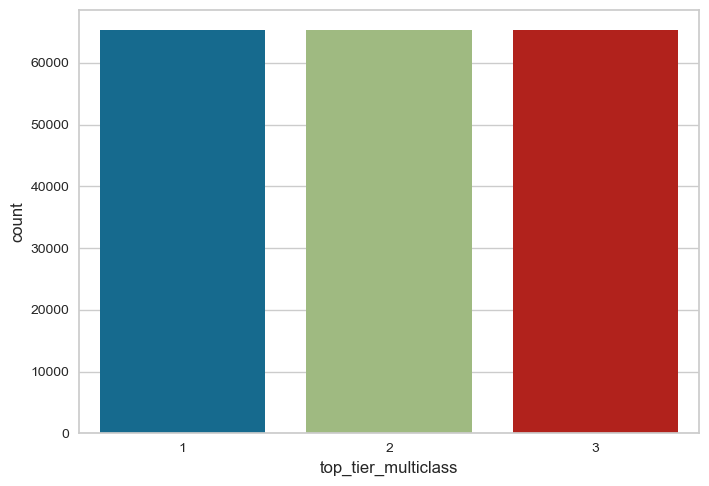

In [52]:
#Addressing Class Imbalance 
#Using a SMOTE Approach to address class imbalance
#SMOTE
sm = SMOTE(random_state=17)

#Resample
X_train, y_train = sm.fit_resample(X_train, y_train)
sns.countplot(x=y_train)
plt.show()

## Exploring Models for Top Tier Average Home Values

1. Naive Bayes
2. Logistic Regression

### 1. Naive Bayes

[[ 8403  1164  1264]
 [ 8178 11620  1987]
 [ 5097  3568  2268]]
              precision    recall  f1-score   support

         Low       0.39      0.78      0.52     10831
      Medium       0.71      0.53      0.61     21785
        High       0.41      0.21      0.28     10933

    accuracy                           0.51     43549
   macro avg       0.50      0.51      0.47     43549
weighted avg       0.56      0.51      0.50     43549



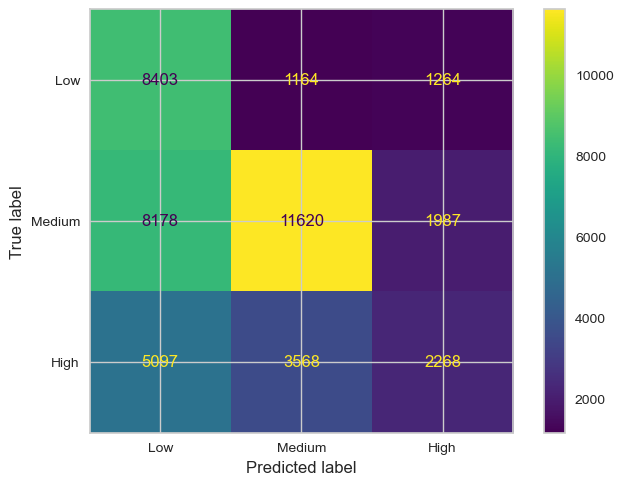

In [53]:
# your code here
modelNB = GaussianNB()

#Training the model
modelNB.fit(X_train, y_train)

#Getting predictions
y_train_pred_NB = modelNB.predict(X_train)
y_test_pred_NB = modelNB.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_NB))

#Labels
labels = ['Low', 'Medium', 'High']
#Print the classification report
print(classification_report(y_test, y_test_pred_NB, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


### 2. Logistic Regression

[[  485  6170  4176]
 [ 1051 14680  6054]
 [  329  3994  6610]]
              precision    recall  f1-score   support

         Low       0.26      0.04      0.08     10831
      Medium       0.59      0.67      0.63     21785
        High       0.39      0.60      0.48     10933

    accuracy                           0.50     43549
   macro avg       0.41      0.44      0.39     43549
weighted avg       0.46      0.50      0.45     43549



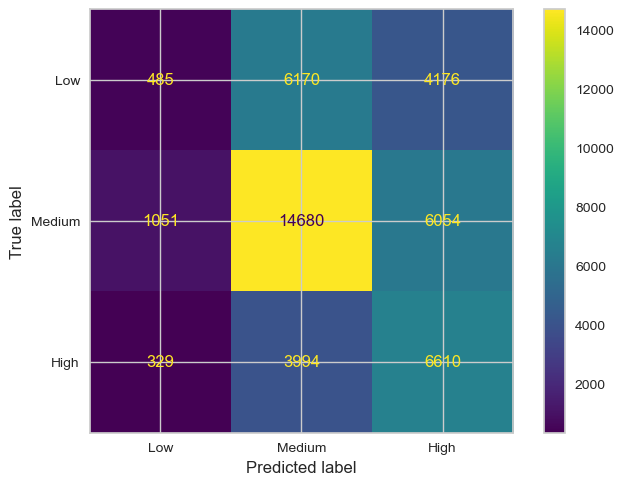

In [54]:
# your code here
model_lr = LogisticRegression(max_iter=10000)

#Fitting the model to SMOTE
model_lr.fit(X_train, y_train)

#Getting predictions
y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_lr))

#Print the classification report
print(classification_report(y_test, y_test_pred_lr, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

#### We will explore more with this dataset, looking at Ratio Changes (for purchase price) and Bottom Tier Average Home Values. We will adjust the classes but will use the insights of this model to look into a clustering question. Overall, the Naive Bayes model we pretty balanced with an accuracy score of 0.51. For the recall, it scored low in classifying for those ratio changes that were low from year to year, so we will be exploring more.  